# Präsenzversuch zum Laval-Rotor

Name: Jakob Knoblach  
Datum: 17.01.2024 
Gruppe: 29

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Wie kann ich die Eigenfrequenz der Prüfstände anhand der Messdaten visualisieren?

## Erster Versuch: Prüfstand #4
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="measurement_data/Pruefstand4.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Der Prüfstand hat ein Scheibe mit einem Gewicht von 1000g. Die Scheibe ist genau in der Mitte zwischen den beiden äußeren Loslagern angebracht.

### Versuchsauswertung

In [2]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [3]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_from_present"
)  # path to the folder with H5-file and metadata
filename = "data_20240117_103720_lavalrotor_29_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [4]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)



##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [5]:
measurement_time_in_s = 10
number_interpolation_points = 2793

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [6]:
#hier wird eine liste mit allen beschleunigungsdaten und den Zeitpunkten erstellt
liste = []

import h5py as h5
for i in range(20):
    with h5.File("measurement_data/data_from_present/data_20240117_103720_lavalrotor_29_04.h5", "r") as f:
        acceleration_x = np.array(f[f"{i}/RawData/1ee823d6-3d20-6332-83f5-6876b760dcf3/acceleration_x"])
        acceleration_y = np.array(f[f"{i}/RawData/1ee823d6-3d20-6332-83f5-6876b760dcf3/acceleration_y"])
        acceleration_z = np.array(f[f"{i}/RawData/1ee823d6-3d20-6332-83f5-6876b760dcf3/acceleration_z"])
        timestamp = np.array(f[f"{i}/RawData/1ee823d6-3d20-6332-83f5-6876b760dcf3/timestamp"])

        
        liste.append({
            "acceleration_x": acceleration_x,
            "acceleration_y": acceleration_y,
            "acceleration_z": acceleration_z,
            "timestamp": timestamp
        })


In [7]:
#hier wird eine Liste erstellt, welche die Beträge aller Vektoren enthält
liste_betrag = []

for i in range(20):
    from functions.m_postprocessing import get_vec_accel
    betrag_der_vektoren = get_vec_accel(liste[i]["acceleration_x"], liste[i]["acceleration_y"], liste[i]["acceleration_z"])
    liste_betrag.append(betrag_der_vektoren)


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [8]:
importlib.reload(m_postprocessing)  # reload functions
from functions.m_postprocessing import interpolation

In [9]:
#Hier wird eine Liste erstellt, welche die Interpolierten Daten enthält
liste_interp = []
for i in range(20):
    #interpolation_points = np.linspace(min(liste[i]["timestamp"]), max(liste[i]["timestamp"]), len(liste[i]["timestamp"]))
    x = interpolation(liste[i]["timestamp"], liste_betrag[i], interpolation_points)
    liste_interp.append(x)


In [10]:
#Hier wird eine Liste erstellt, welche die FFT-Daten enthält
liste_fft = []
for i in range(20):
    from functions.m_postprocessing import my_fft_scaled
    x = my_fft_scaled(liste_interp[i], interpolation_points)
    liste_fft.append(x)
#liste_fft

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

In [11]:
#hier wird eine liste erstellt, welche die Drehzahlen beinhaltet, wichtig für das spätere Diagramm.
liste_rpm = []

for i in range(20):
    with h5.File("measurement_data/data_from_present/data_20240117_103720_lavalrotor_29_04.h5", "r") as f:
        rpm = np.array(f[f"{i}/RawData/1ee823b6-50dc-6670-aea5-35f6dd717e83/motor_rpm"])
        liste_rpm.append(rpm)


In [12]:
matrix_freq = np.zeros((len(liste_fft[1][1]), 20))
for i in range(20):
    matrix_freq[:, i] = liste_fft[i][1]


In [14]:

liste_amplitude = np.zeros((len(liste_fft[1][1]), 20))
for i in range(20):
    liste_amplitude[:, i] = liste_fft[i][0]


In [15]:
#Hier wird die Maximale Amplitude sowie deren Position ermittelt, diese Daten werden für das Plotten des Campbell-Diagramms benötigt
max_amplitude = []
max_values_and_positions = [(np.max(inner_array), np.argmax(inner_array)) for inner_array in liste_amplitude]


for i, (max_value, position) in enumerate(max_values_and_positions):
    print(f"Für NumPy-Array {i + 1}: Maximaler Wert: {max_value}, Position: {position}")

    max_amplitude.append(max_value)


Für NumPy-Array 1: Maximaler Wert: 1.988392279051035e-17, Position: 0
Für NumPy-Array 2: Maximaler Wert: 0.0002037508729386455, Position: 15
Für NumPy-Array 3: Maximaler Wert: 0.0001525269372844041, Position: 16
Für NumPy-Array 4: Maximaler Wert: 0.00020023558256869142, Position: 6
Für NumPy-Array 5: Maximaler Wert: 0.00030815661222243103, Position: 6
Für NumPy-Array 6: Maximaler Wert: 0.0001396098291831355, Position: 19
Für NumPy-Array 7: Maximaler Wert: 0.00011777951719421927, Position: 6
Für NumPy-Array 8: Maximaler Wert: 0.00012543604791192235, Position: 19
Für NumPy-Array 9: Maximaler Wert: 0.00012442157342624222, Position: 15
Für NumPy-Array 10: Maximaler Wert: 0.00018111533950926361, Position: 6
Für NumPy-Array 11: Maximaler Wert: 9.77270706394362e-05, Position: 6
Für NumPy-Array 12: Maximaler Wert: 0.0001300729437686649, Position: 19
Für NumPy-Array 13: Maximaler Wert: 0.0001443621453218252, Position: 6
Für NumPy-Array 14: Maximaler Wert: 0.0001736642231014743, Position: 6
Für 

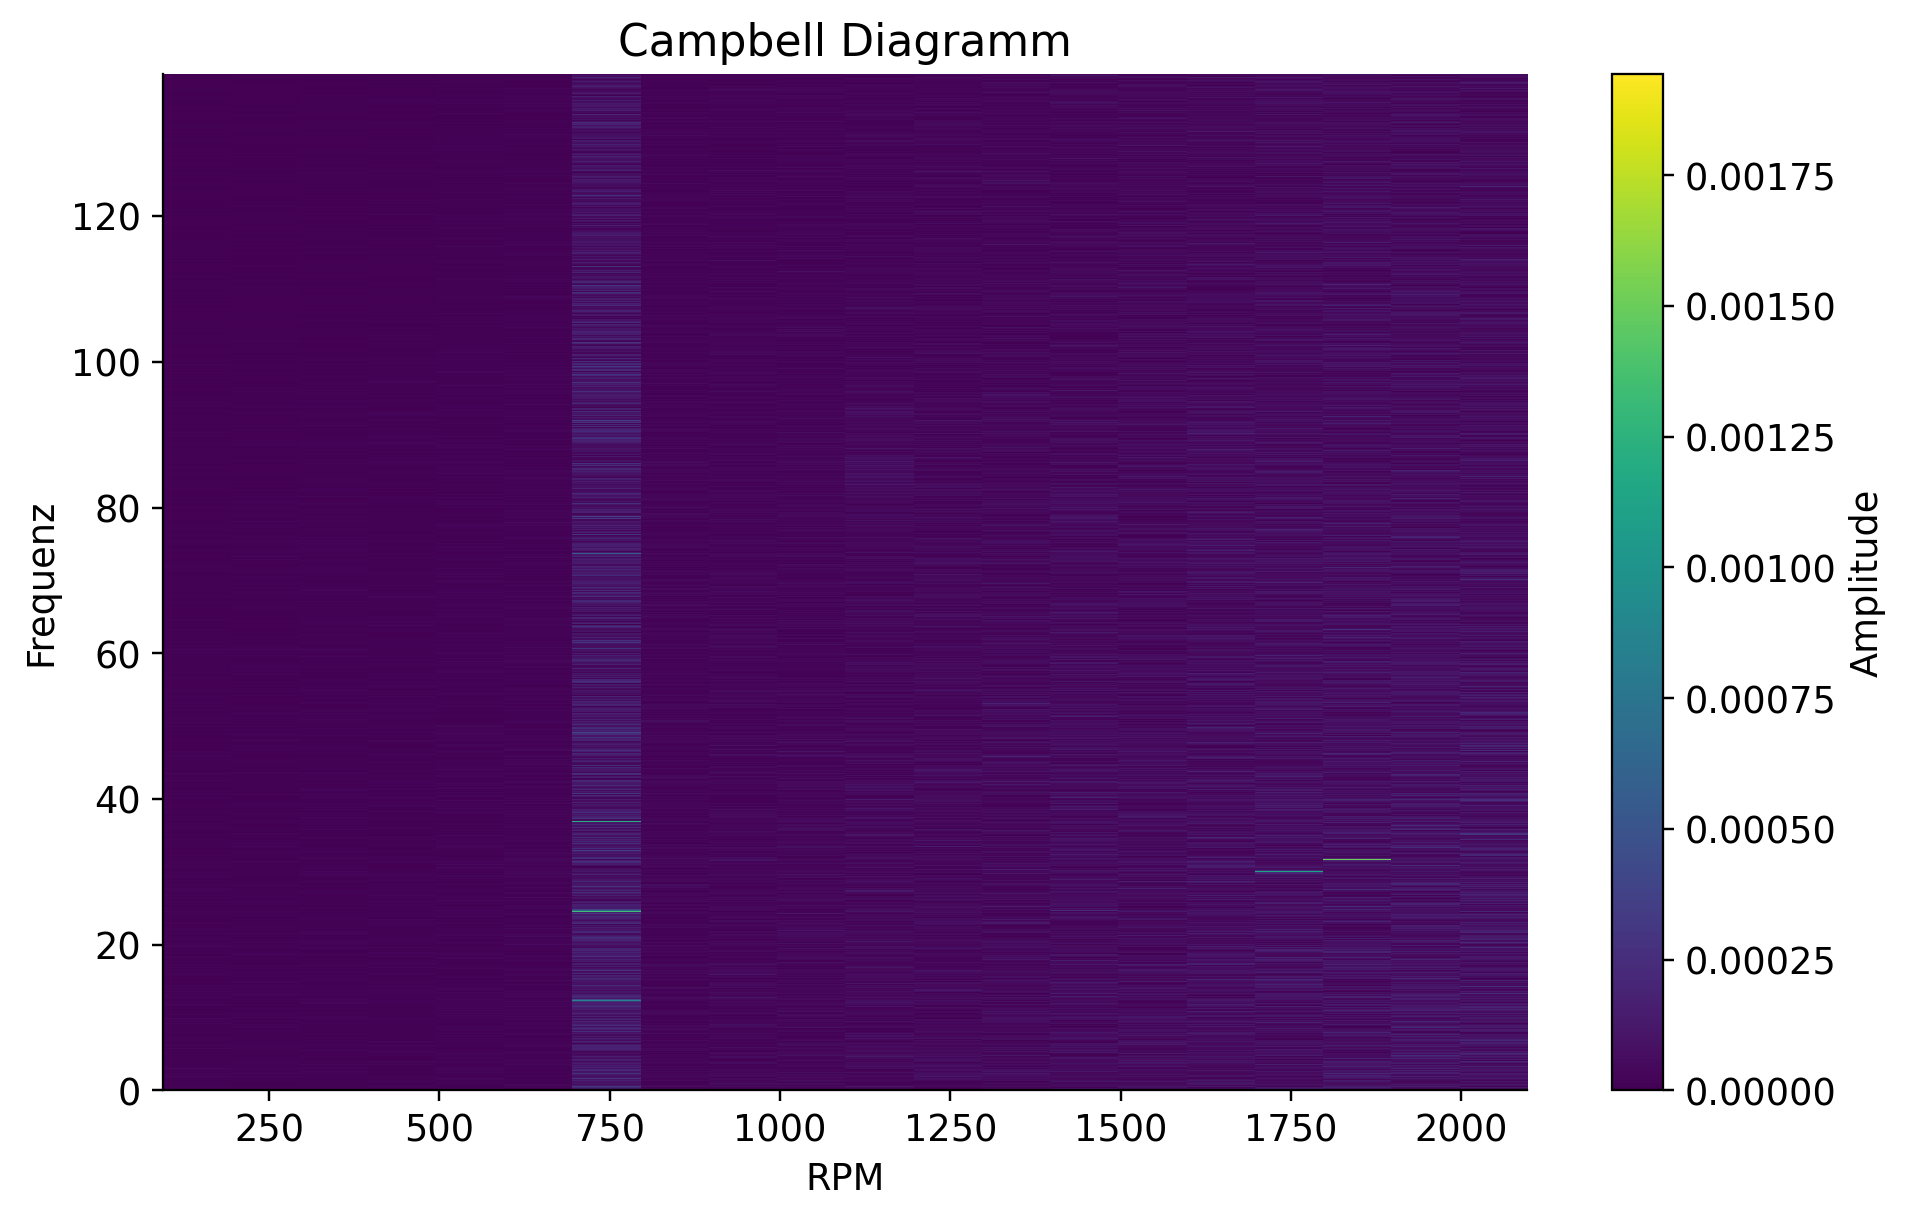

In [18]:
#Hier wird das Ergebnis geplottet
#Max = np.array(max_amplitude).reshape((len(max_amplitude), -1))
plt.figure(figsize=(10, 6))
plt.imshow(liste_amplitude, extent=[ min(liste_rpm), max(liste_rpm), min(matrix_freq[:, 0]), max(matrix_freq[:, 0])],
           aspect='auto', cmap='viridis', interpolation='none', origin='lower')
plt.colorbar(label='Amplitude')

plt.xlabel('RPM')
plt.ylabel('Frequenz')
plt.title('Campbell Diagramm')

plt.show()

## Zweiter Datensatz: Prüfstand #2

#### 1. Einlesen der Mess- und Metadaten

In [19]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

In [20]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

In [21]:
measurement_time_in_s = 10
number_interpolation_points = 2786

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten

In [22]:
#hier wird eine liste mit allen beschleunigungsdaten und den Zeitpunkten erstellt
liste = []

import h5py as h5
for i in range(41):
    with h5.File("measurement_data/data_20240102_100928_lavalrotor_01_02/data_20240102_100928_lavalrotor_01_02.h5", "r") as f:
        acceleration_x = np.array(f[f"{i}/RawData/1ee823d3-8511-6a0b-8cd5-972f083673c9/acceleration_x"])
        acceleration_y = np.array(f[f"{i}/RawData/1ee823d3-8511-6a0b-8cd5-972f083673c9/acceleration_y"])
        acceleration_z = np.array(f[f"{i}/RawData/1ee823d3-8511-6a0b-8cd5-972f083673c9/acceleration_z"])
        timestamp = np.array(f[f"{i}/RawData/1ee823d3-8511-6a0b-8cd5-972f083673c9/timestamp"])

      
        liste.append({
            "acceleration_x": acceleration_x,
            "acceleration_y": acceleration_y,
            "acceleration_z": acceleration_z,
            "timestamp": timestamp
        })



In [23]:
#hier wird eine Liste erstellt, welche die Beträge aller Vektoren enthält
liste_betrag = []

for i in range(41):
    from functions.m_postprocessing import get_vec_accel
    betrag_der_vektoren = get_vec_accel(liste[i]["acceleration_x"], liste[i]["acceleration_y"], liste[i]["acceleration_z"])
    liste_betrag.append(betrag_der_vektoren)


In [24]:
#Hier wird eine Liste erstellt, welche die Interpolierten Daten enthält
from functions.m_postprocessing import interpolation
liste_interp = []
for i in range(41):
    #interpolation_points = np.linspace(min(liste[i]["timestamp"]), max(liste[i]["timestamp"]), len(liste[i]["timestamp"]))
    x = interpolation(liste[i]["timestamp"], liste_betrag[i], interpolation_points)
    liste_interp.append(x)


In [25]:
#Hier wird eine Liste erstellt, welche die FFT-Daten enthält
liste_fft = []
for i in range(41):
    from functions.m_postprocessing import my_fft_scaled
    x = my_fft_scaled(liste_interp[i], interpolation_points)
    liste_fft.append(x)


In [26]:
#Im folgenden wird eine Liste für die Frequenz und eine Liste für die Amplituden erstellt
liste_freq = []
for i in range(41):
    liste_freq.append(liste_fft[i][1])



In [27]:
liste_amplitude = []
for i in range(41):
    liste_amplitude.append(liste_fft[i][0])



In [28]:
#hier wird eine liste erstellt, welche die Drehzahlen beinhaltet, wichtig für das spätere Diagramm.
liste_rpm = []

for i in range(41):
    with h5.File("measurement_data/data_20240102_100928_lavalrotor_01_02/data_20240102_100928_lavalrotor_01_02.h5", "r") as f:
        rpm = np.array(f[f"{i}/RawData/1ee823b3-32d9-6d20-8261-106b0e021eed/motor_rpm"])
        liste_rpm.append(rpm)


#### 3. Darstellung mittels Campbell-Diagramm

In [29]:
#Hier wird die Maximale Amplitude sowie deren Position ermittelt, diese Daten werden für das Plotten des Campbell-Diagramms benötigt
max_amplitude = []
max_values_and_positions = [(np.max(inner_array), np.argmax(inner_array)) for inner_array in liste_amplitude]

# Ausgabe
for i, (max_value, position) in enumerate(max_values_and_positions):
    print(f"Für NumPy-Array {i + 1}: Maximaler Wert: {max_value}, Position: {position}")

    max_amplitude.append(max_value)


Für NumPy-Array 1: Maximaler Wert: 3.720521344940642e-05, Position: 4
Für NumPy-Array 2: Maximaler Wert: 3.70790494232344e-05, Position: 82
Für NumPy-Array 3: Maximaler Wert: 4.4980339213322714e-05, Position: 620
Für NumPy-Array 4: Maximaler Wert: 5.919720696953034e-05, Position: 133
Für NumPy-Array 5: Maximaler Wert: 0.0002795790828998898, Position: 286
Für NumPy-Array 6: Maximaler Wert: 0.00044492790629307197, Position: 347
Für NumPy-Array 7: Maximaler Wert: 0.0007303731074440793, Position: 407
Für NumPy-Array 8: Maximaler Wert: 0.0009026696398231487, Position: 468
Für NumPy-Array 9: Maximaler Wert: 0.0011512602392833849, Position: 528
Für NumPy-Array 10: Maximaler Wert: 0.001258945013985488, Position: 586
Für NumPy-Array 11: Maximaler Wert: 0.00212401701838085, Position: 648
Für NumPy-Array 12: Maximaler Wert: 0.0038430994744717123, Position: 707
Für NumPy-Array 13: Maximaler Wert: 0.0061816843419367565, Position: 767
Für NumPy-Array 14: Maximaler Wert: 0.003851990958828561, Positio

In [31]:
matrix_freq = np.zeros((len(liste_fft[1][1]), 41))
for i in range(41):
    matrix_freq[:, i] = liste_fft[i][1]


In [34]:
liste_amplitude = np.zeros((len(liste_fft[1][1]), 41))
for i in range(41):
    liste_amplitude[:, i] = liste_fft[i][0]


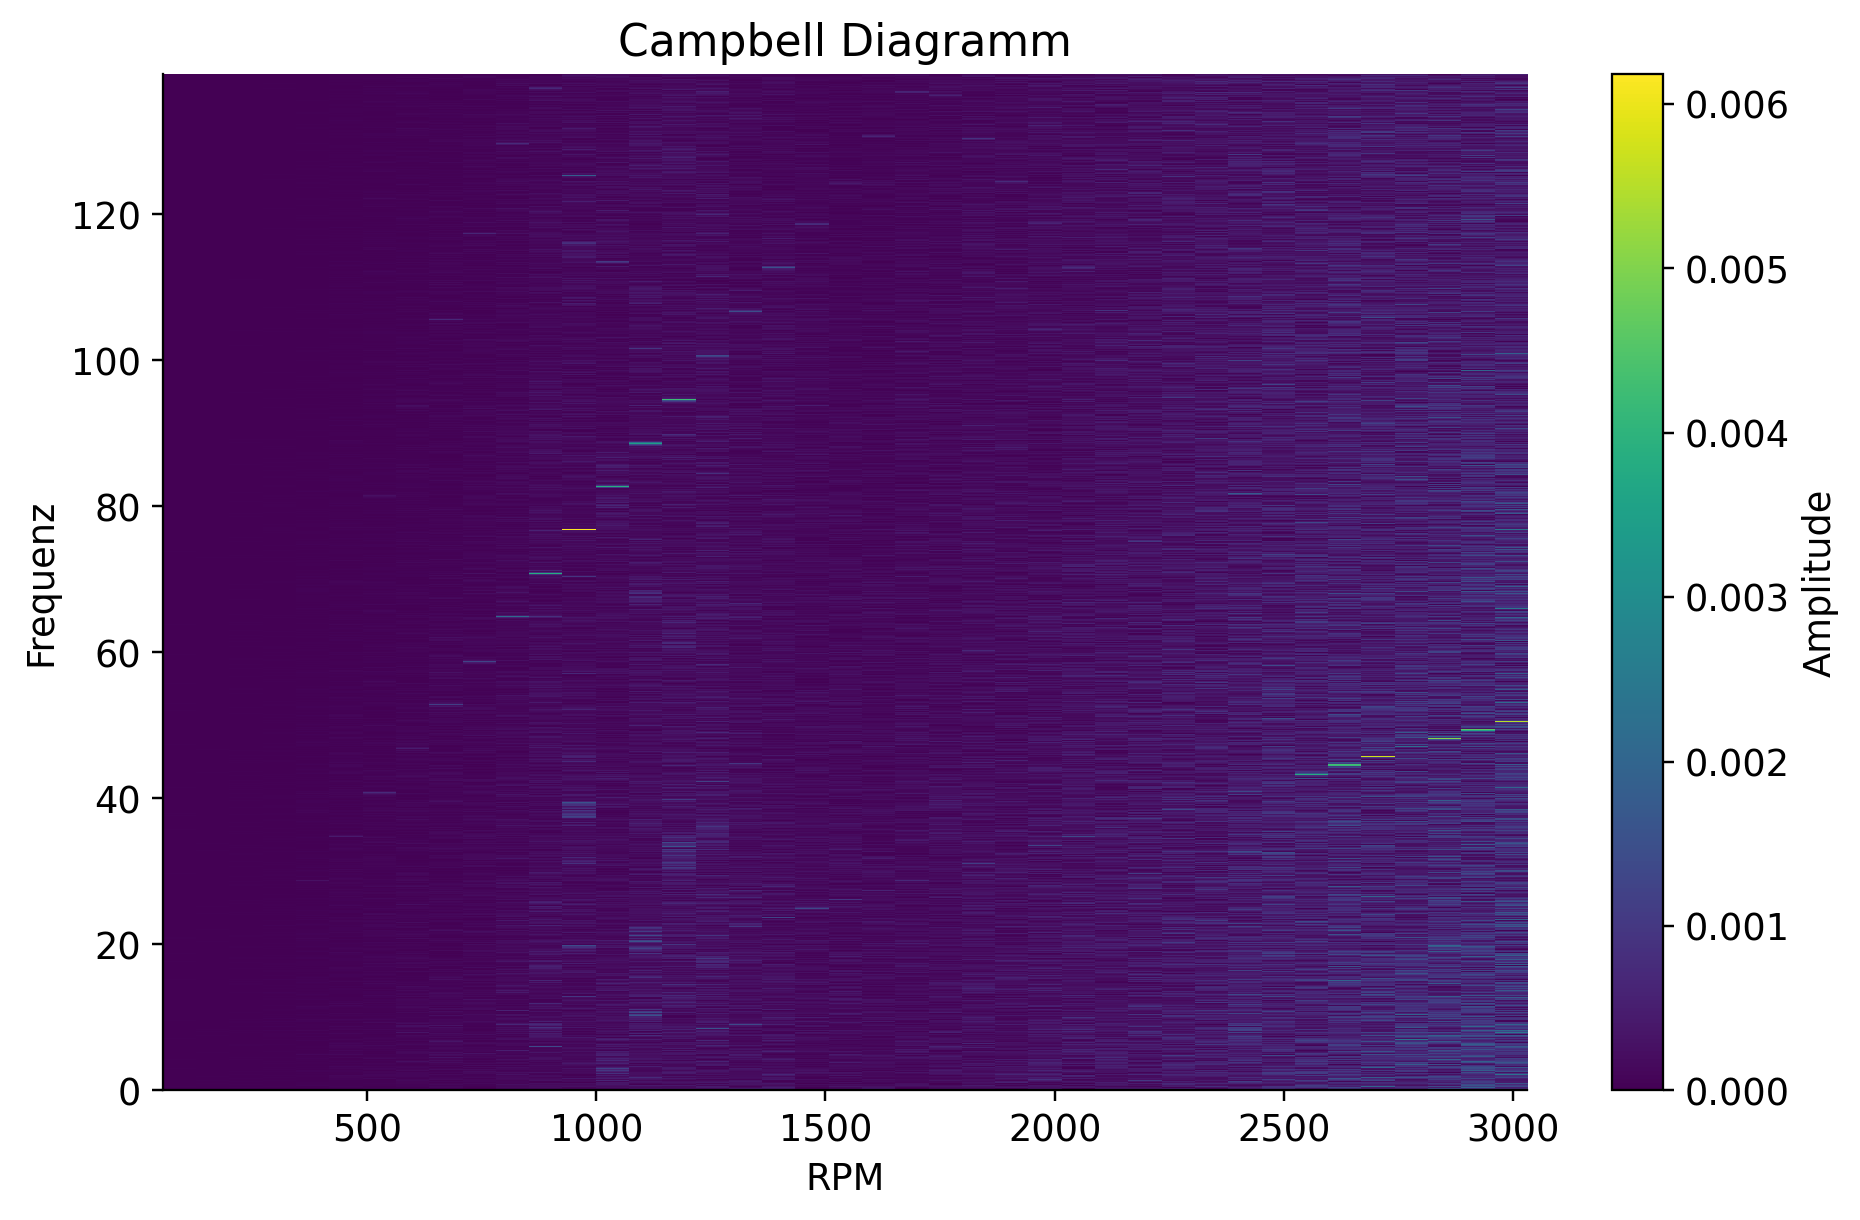

In [35]:
plt.figure(figsize=(10, 6))
plt.imshow(liste_amplitude, extent=[ min(liste_rpm), max(liste_rpm), min(matrix_freq[:, 0]), max(matrix_freq[:, 0])],
           aspect='auto', cmap='viridis', interpolation='none', origin='lower')
plt.colorbar(label='Amplitude')

plt.xlabel('RPM')
plt.ylabel('Frequenz')
plt.title('Campbell Diagramm')

plt.show()

## Dritter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [36]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

In [37]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

In [38]:
measurement_time_in_s = 10
number_interpolation_points = 2854

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [39]:
#hier wird eine liste mit allen beschleunigungsdaten und den Zeitpunkten erstellt
liste = []

import h5py as h5
for i in range(20):
    with h5.File("measurement_data/data_20240102_112539_lavalrotor_01_03/data_20240102_112539_lavalrotor_01_03.h5", "r") as f:
        acceleration_x = np.array(f[f"{i}/RawData/1ee823d5-1451-6df6-a364-c723014c91a1/acceleration_x"])
        acceleration_y = np.array(f[f"{i}/RawData/1ee823d5-1451-6df6-a364-c723014c91a1/acceleration_y"])
        acceleration_z = np.array(f[f"{i}/RawData/1ee823d5-1451-6df6-a364-c723014c91a1/acceleration_z"])
        timestamp = np.array(f[f"{i}/RawData/1ee823d5-1451-6df6-a364-c723014c91a1/timestamp"])

        
        liste.append({
            "acceleration_x": acceleration_x,
            "acceleration_y": acceleration_y,
            "acceleration_z": acceleration_z,
            "timestamp": timestamp
        })



In [40]:
#hier wird eine Liste erstellt, welche die Beträge aller Vektoren enthält
liste_betrag = []

for i in range(20):
    from functions.m_postprocessing import get_vec_accel
    betrag_der_vektoren = get_vec_accel(liste[i]["acceleration_x"], liste[i]["acceleration_y"], liste[i]["acceleration_z"])
    liste_betrag.append(betrag_der_vektoren)


#### 2. Verarbeitung der Messdaten

In [41]:
#Hier wird eine Liste erstellt, welche die Interpolierten Daten enthält
from functions.m_postprocessing import interpolation
liste_interp = []
for i in range(20):
    #interpolation_points = np.linspace(min(liste[i]["timestamp"]), max(liste[i]["timestamp"]), len(liste[i]["timestamp"]))
    x = interpolation(liste[i]["timestamp"], liste_betrag[i], interpolation_points)
    liste_interp.append(x)


In [42]:
#Hier wird eine Liste erstellt, welche die FFT-Daten enthält
liste_fft = []
for i in range(20):
    from functions.m_postprocessing import my_fft_scaled
    x = my_fft_scaled(liste_interp[i], interpolation_points)
    liste_fft.append(x)


In [43]:
#Im folgenden wird eine Liste für die Frequenz und eine Liste für die Amplituden erstellt
liste_freq = []
for i in range(20):
    liste_freq.append(liste_fft[i][1])



In [44]:
liste_amplitude = []
for i in range(20):
    liste_amplitude.append(liste_fft[i][0])



In [45]:
#hier wird eine liste erstellt, welche die Drehzahlen beinhaltet, wichtig für das spätere Diagramm.
liste_rpm = []

for i in range(20):
    with h5.File("measurement_data/data_20240102_112539_lavalrotor_01_03/data_20240102_112539_lavalrotor_01_03.h5", "r") as f:
        rpm = np.array(f[f"{i}/RawData/1ee823b5-5d9b-6f24-9817-906ef09da71d/motor_rpm"])
        liste_rpm.append(rpm)


#### 3. Darstellung mittels Campbell-Diagramm

In [46]:
#Hier wird die Maximale Amplitude sowie deren Position ermittelt, diese Daten werden für das Plotten des Campbell-Diagramms benötigt
max_amplitude = []
max_values_and_positions = [(np.max(inner_array), np.argmax(inner_array)) for inner_array in liste_amplitude]

# Ausgabe
for i, (max_value, position) in enumerate(max_values_and_positions):
    print(f"Für NumPy-Array {i + 1}: Maximaler Wert: {max_value}, Position: {position}")

    max_amplitude.append(max_value)


Für NumPy-Array 1: Maximaler Wert: 3.7507432999134085e-05, Position: 266
Für NumPy-Array 2: Maximaler Wert: 4.3961555091675866e-05, Position: 244
Für NumPy-Array 3: Maximaler Wert: 9.336469497680219e-05, Position: 224
Für NumPy-Array 4: Maximaler Wert: 5.137942975353769e-05, Position: 396
Für NumPy-Array 5: Maximaler Wert: 9.931378144118246e-05, Position: 126
Für NumPy-Array 6: Maximaler Wert: 0.0005059280622994769, Position: 152
Für NumPy-Array 7: Maximaler Wert: 0.0012033687925624263, Position: 177
Für NumPy-Array 8: Maximaler Wert: 0.004083844834779264, Position: 203
Für NumPy-Array 9: Maximaler Wert: 0.006927900278192344, Position: 229
Für NumPy-Array 10: Maximaler Wert: 0.0034629835012814137, Position: 254
Für NumPy-Array 11: Maximaler Wert: 0.0011095961894949408, Position: 279
Für NumPy-Array 12: Maximaler Wert: 0.0012180769812379696, Position: 305
Für NumPy-Array 13: Maximaler Wert: 0.0010541473057805797, Position: 330
Für NumPy-Array 14: Maximaler Wert: 0.0006346316096646416, P

In [47]:
#hier wird die Frequenz an der Position ausgegeben, an welcher die Amplitude maximal ist
max_freq = []
for i in range(20):
    y = liste_freq[i][1]
    max_freq.append(y)


In [48]:
matrix_freq = np.zeros((len(liste_fft[1][1]), 20))
for i in range(20):
    matrix_freq[:, i] = liste_fft[i][1]


In [50]:
liste_amplitude = np.zeros((len(liste_fft[1][1]), 20))
for i in range(20):
    liste_amplitude[:, i] = liste_fft[i][0]


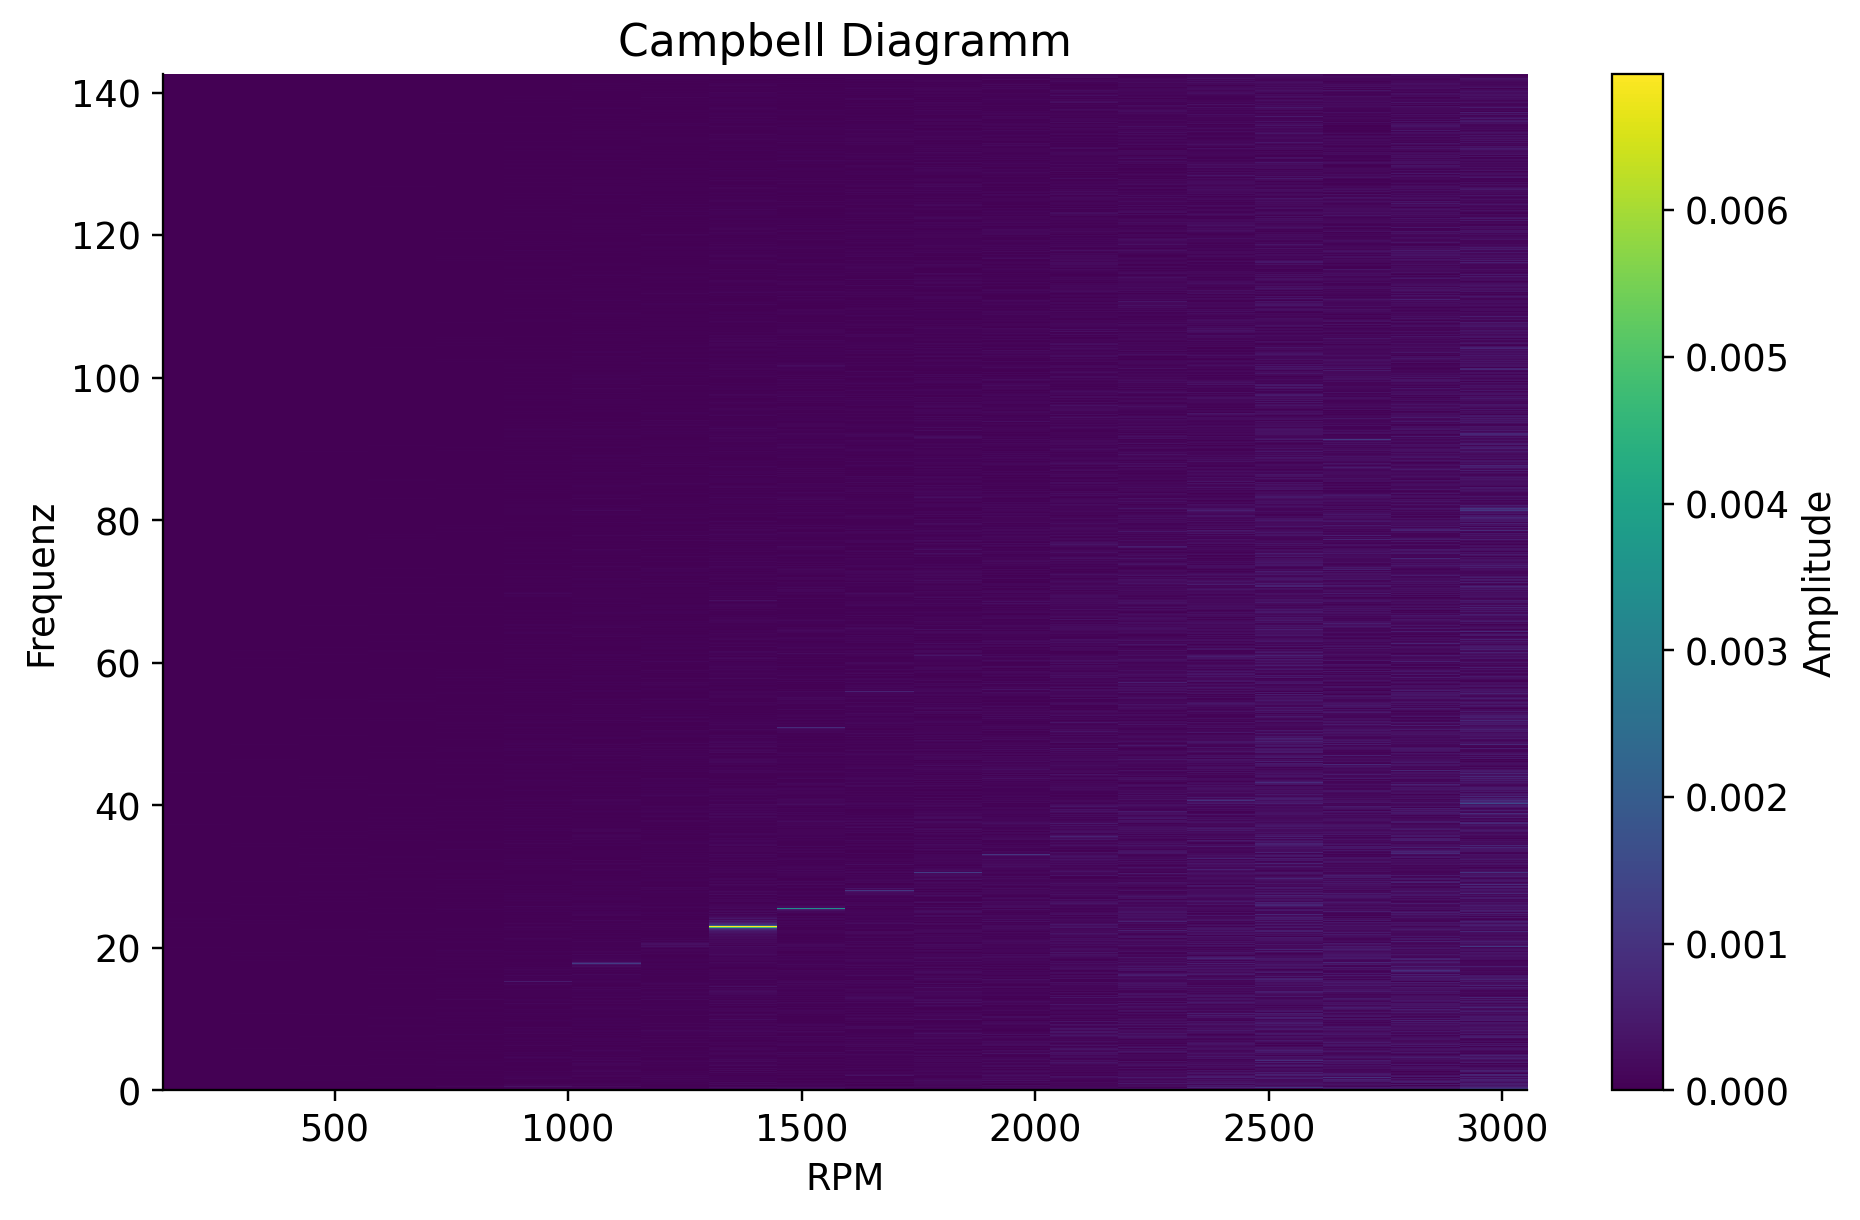

In [51]:
plt.figure(figsize=(10, 6))
plt.imshow(liste_amplitude, extent=[ min(liste_rpm), max(liste_rpm), min(matrix_freq[:, 0]), max(matrix_freq[:, 0])],
           aspect='auto', cmap='viridis', interpolation='none', origin='lower')
plt.colorbar(label='Amplitude')

plt.xlabel('RPM')
plt.ylabel('Frequenz')
plt.title('Campbell Diagramm')

plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Bei dem Ersten Diagramm kann man erkennen, dass die Eigenfrequenz bei 750 RPM liegt. Im zweiten Diagramm kann man erkennen, dass zwei Eigenfrequenzen vorliegen. Eine zwischen 900 und 1300RPM und die andere zwischen 2400 und 3000.  Dem dritten Diagramm kann man entnehmen, dass bei 1300 Umdrehung eine große Amplitude im Vergleich zu den anderen Umdrehungen und Frequenzen vorliegt.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Während des Präsenzversuches hat der Prüfstand ab einer Umdrehung von ungefähr 750RPM begonnen stark zu vibrieren, was darauf schließt dass diese Drehzahl die Eigenfrequenz des Systems darstellt. Beim berechnen kamen wir auf eine Drehzahl von ungefähr 500RPM. Unser Betreuer meinte, dieses Ergebnis ist trotzdem richtig, da es um die Größenordnung geht. Wir sind damit nicht im Einer-Bereich und auch nicht im Zehntausender-Bereich.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Ich kann jetzt final sehr gut mit hdf5 Datein umgehen und mit diesen Arbeiten. Das Auslesen der Daten und diese in eine Liste hinzuzufügen fällt mir mitlerweile um einiges Leichter als am Anfang dieses Moduls. Ich weis jetzt was Campbell-Diagramme sind und für was man diese braucht. 